In [1]:
from data_preprocess import *
from train_and_test import *
from config_loader import *

跑通model_v1

In [2]:
model_name = 'model_v1'
# 参数
model_config = models_config[model_name]
batch_size, lr, optim_name, epochs, metric, alpha = (
    model_config['batch_size'],
    model_config['lr'],
    model_config['optimizer'],
    model_config['epochs'],
    model_config['metric'],
    model_config.get('alpha', None)
)

# 数据
batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
train_df, val_df, test_df, train_loader, val_loader, test_loader = load_data(batteries_df, val_bat, test_bat, seq_length, batch_size)

# 模型、优化器
model = get_model(model_config, device)
optimizer = get_optimizer(optim_name, model, lr, alpha)
criterion = nn.MSELoss()

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [3]:
# 训练、验证
model_save_filename = 'test1'

best_val_re = float('inf')
for epoch in range(epochs):
    train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
    val_loss = test_epoch(model_config, model, test_loader, device, criterion)
    # 从第一个窗口开始迭代预测，得到预测曲线（包含第一个窗口）
    val_seq, sp = val_df['capacity'].to_numpy(), 0.0
    pred_seq = predict(model_config, model, sp, val_seq, seq_length, failure_threshold, device)
    re, rmse, mae = cal_metrics(val_seq, pred_seq, sp, seq_length, failure_threshold)

    print(f"Model: {model_name}, Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}, Val RE: {re:.3f}, Val RMSE: {rmse:.4f}, Val MAE: {mae:.4f}")
    
    if re < best_val_re:
        best_val_re = re
        saved_re, saved_rmse, saved_mae = re, rmse, mae
        torch.save(model.state_dict(), '{}/{}.pth'.format(model_save_dir, model_save_filename))
        print("New best model saved ...")

Model: model_v1, Epoch [1/200], Train Loss: 0.21385408, Val Loss: 0.04141757, Val RE: 1.000, Val RMSE: 0.0946, Val MAE: 0.0847
New best model saved ...
Model: model_v1, Epoch [2/200], Train Loss: 0.03387926, Val Loss: 0.02127674, Val RE: 1.000, Val RMSE: 0.1527, Val MAE: 0.1468
Model: model_v1, Epoch [3/200], Train Loss: 0.01712035, Val Loss: 0.00131820, Val RE: 1.000, Val RMSE: 0.0557, Val MAE: 0.0404
Model: model_v1, Epoch [4/200], Train Loss: 0.00881949, Val Loss: 0.00078673, Val RE: 1.000, Val RMSE: 0.0483, Val MAE: 0.0313
Model: model_v1, Epoch [5/200], Train Loss: 0.00658931, Val Loss: 0.00093906, Val RE: 1.000, Val RMSE: 0.0460, Val MAE: 0.0293
Model: model_v1, Epoch [6/200], Train Loss: 0.00545617, Val Loss: 0.00089106, Val RE: 1.000, Val RMSE: 0.0382, Val MAE: 0.0291
Model: model_v1, Epoch [7/200], Train Loss: 0.00448575, Val Loss: 0.00100229, Val RE: 1.000, Val RMSE: 0.0523, Val MAE: 0.0343
Model: model_v1, Epoch [8/200], Train Loss: 0.00410846, Val Loss: 0.00112810, Val RE: 

KeyboardInterrupt: 

In [6]:
# 测试
sp = 0.0

# 加载模型
model_config = models_config[model_name]
model_path = os.path.join(model_save_dir, model_save_filename + '.pth')
model = get_model(model_config, device)
model.load_state_dict(torch.load(model_path, map_location=device))

# 预测
pred_seq = predict(model_config, model, sp, val_seq, seq_length, failure_threshold, device)
re, rmse, mae = cal_metrics(val_seq, pred_seq, sp, seq_length, failure_threshold)

/var/folders/6x/w_phznyd4830j7jb8y12rhrc0000gn/T/ipykernel_46872/2601447883.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

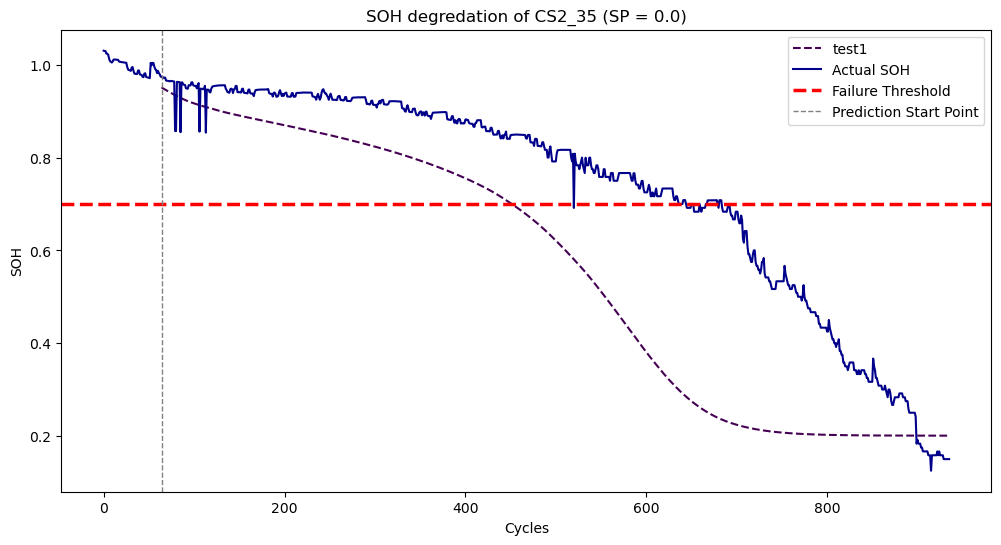

In [7]:
# plot
pred_seqs = {model_save_filename: pred_seq}
plot(val_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)